# Extraction of consistent signatures

This notebook demostrate how to extract consisent microbiome signatures from multiple sub-models.

To figure out the contribution magnitude of each feature to prediction outcome, SHAP values were applied to untangle the prediction model and quantify each feature's contribution within it. The final output of this step is a table of microbiome signature.

![extraction of consistent signatures](notebooks/images/extraction_of_consistent_signatures.png)

In [2]:
import warnings
import numpy as np
import pandas as pd
import pickle
import plotly
import os
import shap
import sys
import xgboost as xgb
from scipy.special import expit
from collections import defaultdict
from functools import reduce
from sklearn.manifold import TSNE
from tqdm import tqdm

sys.path.insert(0, '../../t2d_gut_microbiome_signatures')
from signature.feature import get_feature_shap_scores, rank_shap_scores
from dataset.GGMP import load_data as ggmp_data
from dataset.SGMP import load_data as sgmp_data

warnings.filterwarnings("ignore")
shap.initjs()

### Interpretable features values

Since our base learner (XGBoost) already support SHAP, we've already save SHAP values in former step (base learner predicts the probability of T2D, SHAP values are generated in the meanwhile). This demostration load SHAP values and visualize feature contribution to prediction scores.

In [2]:
# load data of feature contribution of base learner
# take one of those learners as example to summarize contribution of features on each sample
shap_values = pd.read_table('output/ensemble_of_predictive_models/subsample-1_shap_valid.tsv')
shap_values.set_index('SampleID', inplace=True)
shap_values.drop(columns=['bias', 'label', 'District'], inplace=True)

# load training data
taxa = pd.read_table('output/ensemble_of_predictive_models/data_X.tsv',
                     index_col=0).reindex(shap_values.index.values)

In [3]:
print(shap_values.shape)
shap_values.head()

(100, 361)


k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter  \
SampleID                                                                                                                        
G440104170                                                0.0                                                                   
G440205200                                                0.0                                                                   
G440205295                                                0.0                                                                   
G440205650                                                0.0                                                                   
G440282293                                                0.0                                                                   

            k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera  \
SampleID                                                                                                                    
G440104170                                                0.0                                                               
G440205200                                                0.0                                                               
G440205295                                                0.0                                                               
G440205650                                                0.0                                                               
G440282293                                                0.0                                                               

            k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__E2;f__ Methanomassiliicoccaceae ;g__vadinCA11  \
SampleID                                                                                                     
G440104170                                                0.0                                                
G440205200                                                0.0                                                
G440205295                                                0.0                                                
G440205650                                                0.0                                                
G440282293                                                0.0                                                

            k__Bacteria;p__Acidobacteria;c__ Chloracidobacteria ;o__RB41;f__Ellin6075;g__  \
SampleID                                                                                    
G440104170                                                0.0                               
G440205200                                                0.0                               
G440205295                                                0.0                               
G440205650                                                0.0                               
G440282293                                                0.0                               

            k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__  \
SampleID                                                                                                 
G440104170                                                0.0                                            
G440205200                                                0.0                                            
G440205295                                                0.0                                            
G440205650                                                0.0                                            
G440282293                                                0.0                                            

            k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Act

In [4]:
print(taxa.shape)
taxa.head()

(100, 361)


k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter  \
SampleID                                                                                                                        
G440104170                                             0.0000                                                                   
G440205200                                             0.0002                                                                   
G440205295                                             0.0000                                                                   
G440205650                                             0.0026                                                                   
G440282293                                             0.0000                                                                   

            k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera  \
SampleID                                                                                                                    
G440104170                                                0.0                                                               
G440205200                                                0.0                                                               
G440205295                                                0.0                                                               
G440205650                                                0.0                                                               
G440282293                                                0.0                                                               

            k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__E2;f__ Methanomassiliicoccaceae ;g__vadinCA11  \
SampleID                                                                                                     
G440104170                                                0.0                                                
G440205200                                                0.0                                                
G440205295                                                0.0                                                
G440205650                                                0.0                                                
G440282293                                                0.0                                                

            k__Bacteria;p__Acidobacteria;c__ Chloracidobacteria ;o__RB41;f__Ellin6075;g__  \
SampleID                                                                                    
G440104170                                                0.0                               
G440205200                                                0.0                               
G440205295                                                0.0                               
G440205650                                                0.0                               
G440282293                                                0.0                               

            k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__  \
SampleID                                                                                                 
G440104170                                                0.0                                            
G440205200                                                0.0                                            
G440205295                                                0.0                                            
G440205650                                                0.0                                            
G440282293                                                0.0                                            

            k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Act

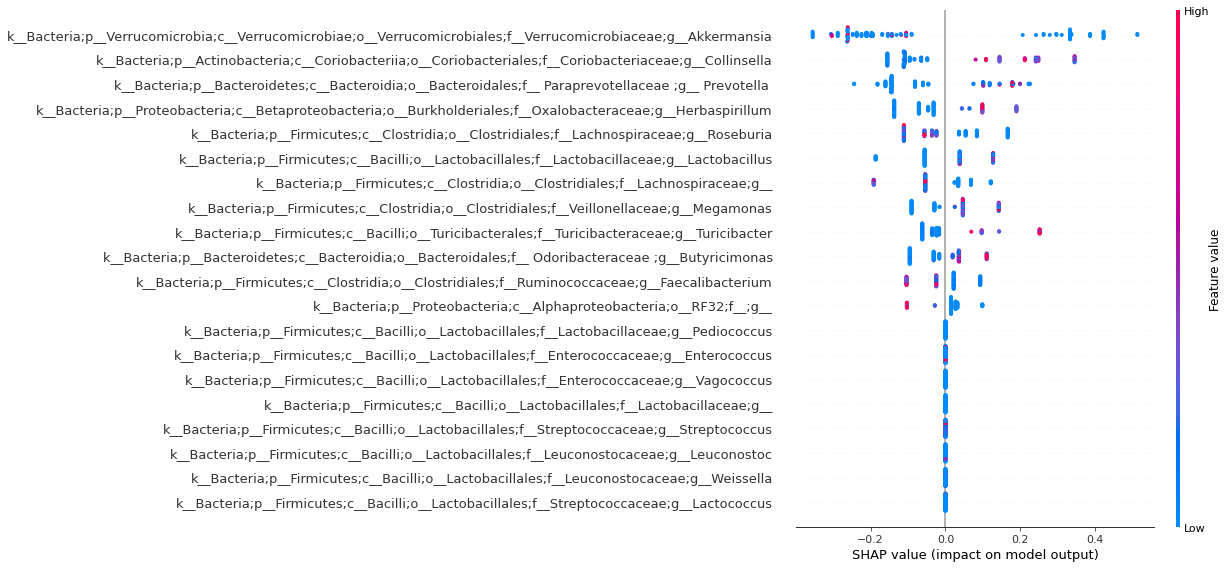

In [5]:
shap.summary_plot(shap_values.values, taxa)

### Feature ranking across models

Due to the complexity of random selected samples from two large cohorts, contribution of features might be various in different sub-models. Features consitently contribute to prediction score in sub-models are emphasised. We devised a strategy to compare the ranking of microbiome features regarding their importance between region-specific models, to identifiy consistent microbiome features for T2DM prediction and eliminate region-bias.

![feautre ranking](images/feature_ranking_across_models.png)

demostrate with 2 sub-models:

In [6]:
infile1 = 'output/ensemble_of_predictive_models/subsample-1_shap_valid.tsv'
infile2 = 'output/ensemble_of_predictive_models/subsample-2_shap_valid.tsv'
drop_columns = ['SampleID', 'bias', 'label', 'District']

# transform feature contribution to score metric based on SHAP values and prediction
scores1 = get_feature_shap_scores(infile1, drop_columns)
scores2 = get_feature_shap_scores(infile2, drop_columns)

scores1.name = 'learner_1'
scores2.name = 'learner_2'
df = pd.concat([scores1, scores2],
               axis=1,
               sort=False)
df.head(10)

learner_1  learner_2
k__Bacteria;p__Verrucomicrobia;c__Verrucomicrob...   0.094693  -0.002028
k__Bacteria;p__Actinobacteria;c__Coriobacteriia...   0.060386   0.034870
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clos...   0.032355   0.238092
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactoba...   0.028666   0.158580
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__...   0.023897   0.029167
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clos...   0.014205   0.061738
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clos...   0.012303   0.036014
k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__...   0.004977   0.000000
k__Bacteria;p__Firmicutes;c__Bacilli;o__Turicib...   0.000478   0.012629
k__Bacteria;p__Tenericutes;c__Mollicutes;o__Ana...   0.000000   0.000000

/media/cy/anaconda3/envs/py38/lib/python3.8/site-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



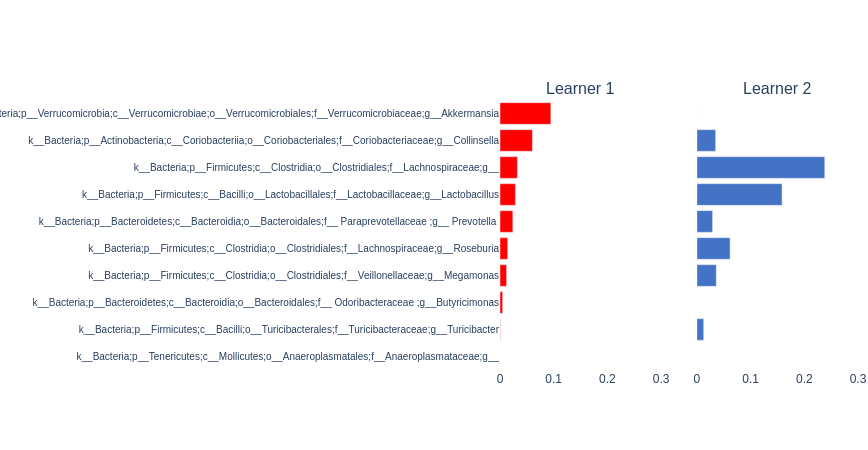

In [7]:
fig = plotly.tools.make_subplots(rows=1, cols=2, 
                                 shared_yaxes=True, 
                                 subplot_titles=['Learner 1', 'Learner 2'])
fig.append_trace(plotly.graph_objs.Bar(y=df.head(10).index.values[::-1],
                                       x=df.head(10).learner_1.values[::-1],
                                       marker=dict(color='#FF0000'),
                                       orientation='h'), 1, 1)
fig.append_trace(plotly.graph_objs.Bar(y=df.head(10).index.values[::-1],
                                       x=df.head(10).learner_2.values[::-1],
                                       marker=dict(color='#4472C4'),
                                       orientation='h'), 1, 2)
fig.update_layout(autosize=True,
                  showlegend=False,
                  paper_bgcolor='#FFFFFF',
                  plot_bgcolor='#FFFFFF',
                  margin=dict(l=500, r=10),
                  yaxis=dict(tickfont=dict(size=10)))
fig.update_xaxes(range=[0, 0.3])
fig.show()

The feature scores ranks are quiet different between two demostrated sub-models. Integrating feature rankings across all predictive sub-models to figure out consistent feature.

In [3]:
# load retained model name first
_model = pickle.load(open('output/ensemble_of_predictive_models/model_retained_idx.pkl', 'rb'))
print(f'retained models: {len(_model)} / 1000')

retained models: 1000 / 1000


In [9]:
# take shap values of validation set for example.
infiles = [f'output/ensemble_of_predictive_models/{_}_shap_valid.tsv' for _ in _model]
# calculate scores according to shap values and accuracy of prediction
shap_scores = [get_feature_shap_scores(_, drop_columns=drop_columns) for _ in infiles]
# rank scores based on the consistent performance in all model retained
shap_ranks = rank_shap_scores(shap_scores, rank_n=len(_model))
shap_ranks.name = 'observed'
shap_ranks.head()

k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__                                   0.791479
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus                      0.623284
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__Shigella       0.559905
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Megamonas                          0.509528
k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia    0.468727
Name: observed, dtype: float64

In [10]:
# calculate scores and rank them on 100 null models corresponded to retained models respectively.
null_ranks = []
for i in tqdm(range(1, 100 + 1)):
    infiles = [f'output/ensemble_of_predictive_models/null/{_}_p_{i}_shap_valid.tsv' for _ in _model]
    _scores = [get_feature_shap_scores(_, drop_columns=drop_columns + ['shuffle']) for _ in infiles]
    _rank = rank_shap_scores(_scores, rank_n=len(_model))
    _rank.name = f'null_{i}'
    null_ranks.append(_rank)

# concatenate result ranking of shap scores from both real model and null models
ranking_valid = pd.concat([shap_ranks] + null_ranks, 
                         axis=1,
                         sort=False)     

100%|██████████| 100/100 [1:51:03<00:00, 66.64s/it]


In [11]:
# Rank the feature from testing set and get results
infiles = [f'output/ensemble_of_predictive_models/{_}_shap_test.tsv' for _ in _model]
shap_scores = [get_feature_shap_scores(_, drop_columns=drop_columns) for _ in infiles]
shap_ranks = rank_shap_scores(shap_scores, rank_n=len(_model))
shap_ranks.name = 'observed'

null_ranks = []
for i in tqdm(range(1, 100 + 1)):
    infiles = [f'output/ensemble_of_predictive_models/null/{_}_p_{i}_shap_test.tsv' for _ in _model]
    _scores = [get_feature_shap_scores(_, drop_columns=drop_columns + ['shuffle']) for _ in infiles]
    _rank = rank_shap_scores(_scores, rank_n=len(_model))
    _rank.name = f'null_{i}'
    null_ranks.append(_rank)
    
# concatenate result ranking of shap scores from both real model and null models
ranking_test = pd.concat([shap_ranks] + null_ranks, 
                         axis=1,
                         sort=False)  

100%|██████████| 100/100 [1:38:00<00:00, 58.81s/it]


The feature selection is done according to the results of feature ranking. Ranking score of feature retained should be significant larger than null ranking scores, for both validation set and testing set.

In [12]:
# select significant feature by comparison observed ranking scores with null ranking scores for each feature respectively
significant_p = 0.95
cond_valid = ranking_valid.ge(ranking_valid.observed, axis='index').sum(1) < (1 - significant_p)*100
cond_test = ranking_test.ge(ranking_test.observed, axis='index').sum(1) < (1 - significant_p)*100
signif_feature = ranking_valid.index[cond_valid].intersection(ranking_test.index[cond_test])
print(len(signif_feature))
print(signif_feature)

26
Index(['k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__',
       'k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus',
       'k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__Shigella',
       'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Veillonellaceae;g__Megamonas',
       'k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia',
       'k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium',
       'k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Burkholderiales;f__Alcaligenaceae;g__Sutterella',
       'k__Bacteria;p__Actinobacteria;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriaceae;g__Collinsella',
       'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium',
       'k__Bacteria

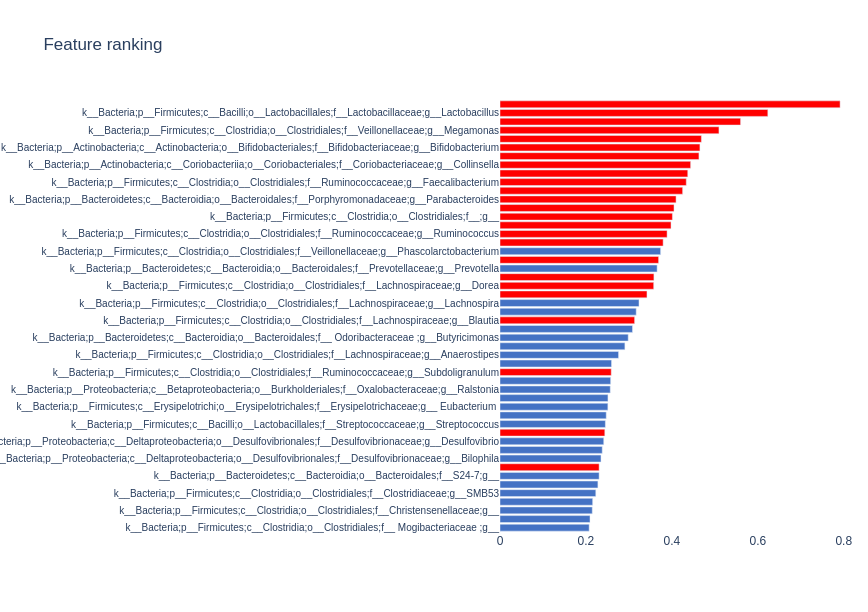

In [13]:
# visualization of ranking (color red for selected significant features)
fig = plotly.graph_objs.Figure()
fig.add_trace(plotly.graph_objs.Bar(y=ranking_valid.head(50).index.values[::-1],
                                    x=ranking_valid.head(50).observed.values[::-1],
                                    marker=dict(color=['#FF0000' if _ in signif_feature else '#4472C4' for _ in ranking_valid.head(50).index.values[::-1]]),
                                    orientation='h'))
fig.update_layout(title='Feature ranking',
                  autosize=True,
                  showlegend=False,
                  paper_bgcolor='#FFFFFF',
                  plot_bgcolor='#FFFFFF',
                  margin=dict(l=500, r=10),
                  yaxis=dict(tickfont=dict(size=10)))
fig.update_layout(width=1000, height=600)
fig.show()

We also apply these procedure to GGMP cohort and SGMP cohort independently, 26 significant features and 49 significant features remained respectively. Finally, <strong>seven</strong> of these significant features are chosen to be <strong>consistent features</strong>, since they are <strong>shared in not only the cross-cohort model and intra-cohort models</strong>, with the same direction of correlation between microbiome signatures and relative abundance (see Table S1.xlsx for more detail). The 7 consistent features are:

In [4]:
features = """k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium
k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus""".split("\n")
print("\n".join(features))

k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium
k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__
k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus
k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Coprococcus


### Microbiome signatures

The microbiome signatures are generated by mean SHAP values of consistent features according to feature ranking

![generate microbiome signatures](images/generate_microbiome_signatures.png)

In order to obtain microbiome signatures for all samples, we predict combined dataset on each retained model, and interprete it with SHAP values. Take one of retained model for example to demostrate how <del>these consistent</del> features impact the prediction output of each sample.

In [5]:
ggmp_metadata_file = 'data/GGMP/sample-metadata.tsv'
ggmp_genus_table_file = 'data/GGMP/table-filtered-feature-rarefied5k-L6.tsv'
ggmp_metadata = ggmp_data.get_disease_and_healthy(ggmp_metadata_file)
print(ggmp_metadata.shape)

(2603, 74)


In [6]:
sgmp_metadata_file = 'data/SGMP/sample-metadata.tsv'
sgmp_genus_table_file = 'data/SGMP/table-filtered-feature-rarefied5k-L6.tsv'
sgmp_metadata = pd.read_table(sgmp_metadata_file, index_col=0, dtype={'sample_ID': str})
print(sgmp_metadata.shape)

(2012, 4)


In [7]:
dfi_metadata_file = 'data/DFI/sample-metadata.tsv'
dfi_genus_table_file = 'data/DFI/table-filtered-feature-rarefied5k-L6.tsv'
dfi_metadata = pd.read_table(dfi_metadata_file, index_col=0, dtype={'sample_ID': str})
print(dfi_metadata.shape)

(305, 4)


In [8]:
tmp = pd.concat([ggmp_data.get_genus_table_for_xgb(ggmp_genus_table_file),
                 sgmp_data.get_genus_table_for_xgb(sgmp_genus_table_file),
                 sgmp_data.get_genus_table_for_xgb(dfi_genus_table_file)],
              axis=0,
              sort=False).fillna(0)

ggmp_genus_table = tmp.reindex(ggmp_metadata.index)
sgmp_genus_table = tmp.reindex(sgmp_metadata.index)
dfi_genus_table = tmp.reindex(dfi_metadata.index)

In [9]:
print(ggmp_genus_table.shape)
ggmp_genus_table.head()

(2603, 361)


k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter  \
SampleID                                                                                                                        
G440606620                                             0.0010                                                                   
G445224247                                             0.0002                                                                   
G440305382                                             0.0000                                                                   
G441502202                                             0.0000                                                                   
G445302201                                             0.0002                                                                   

            k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera  \
SampleID                                                                                                                    
G440606620                                                0.0                                                               
G445224247                                                0.0                                                               
G440305382                                                0.0                                                               
G441502202                                                0.0                                                               
G445302201                                                0.0                                                               

            k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__E2;f__ Methanomassiliicoccaceae ;g__vadinCA11  \
SampleID                                                                                                     
G440606620                                                0.0                                                
G445224247                                                0.0                                                
G440305382                                                0.0                                                
G441502202                                                0.0                                                
G445302201                                                0.0                                                

            k__Bacteria;p__Acidobacteria;c__ Chloracidobacteria ;o__RB41;f__Ellin6075;g__  \
SampleID                                                                                    
G440606620                                                0.0                               
G445224247                                                0.0                               
G440305382                                                0.0                               
G441502202                                                0.0                               
G445302201                                                0.0                               

            k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__  \
SampleID                                                                                                 
G440606620                                                0.0                                            
G445224247                                                0.0                                            
G440305382                                                0.0                                            
G441502202                                                0.0                                            
G445302201                                                0.0                                            

            k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Act

In [10]:
print(sgmp_genus_table.shape)
sgmp_genus_table.head()

(2012, 361)


k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter  \
SampleID                                                                                                                            
sam-570                                                       0.0                                                                   
sam-477                                                       0.0                                                                   
JN-MF2-15520                                                  0.0                                                                   
JN-MF2-15218                                                  0.0                                                                   
JN-TMF2-SD0168                                                0.0                                                                   

                k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera  \
SampleID                                                                                                                        
sam-570                                                       0.0                                                               
sam-477                                                       0.0                                                               
JN-MF2-15520                                                  0.0                                                               
JN-MF2-15218                                                  0.0                                                               
JN-TMF2-SD0168                                                0.0                                                               

                k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__E2;f__ Methanomassiliicoccaceae ;g__vadinCA11  \
SampleID                                                                                                         
sam-570                                                       0.0                                                
sam-477                                                       0.0                                                
JN-MF2-15520                                                  0.0                                                
JN-MF2-15218                                                  0.0                                                
JN-TMF2-SD0168                                                0.0                                                

                k__Bacteria;p__Acidobacteria;c__ Chloracidobacteria ;o__RB41;f__Ellin6075;g__  \
SampleID                                                                                        
sam-570                                                       0.0                               
sam-477                                                       0.0                               
JN-MF2-15520                                                  0.0                               
JN-MF2-15218                                                  0.0                               
JN-TMF2-SD0168                                                0.0                               

                k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__  \
SampleID                                                                                                     
sam-570                                                       0.0                                            
sam-477                                                       0.0                                            
JN-MF2-15520                                                  0.0                                            
JN-MF2-15218                                                  0.0                                            
JN-TMF2-SD0168                           

In [11]:
print(dfi_genus_table.shape)
dfi_genus_table.head()

(305, 361)


k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter  \
SampleID                                                                                                                             
DF-TMF10-15039                                                 0.0                                                                   
DF-TMF10-BQ1418                                                0.0                                                                   
DF-TMF10-CY3434                                                0.0                                                                   
DF-TMF10-BQ2518                                                0.0                                                                   
DF-TMF10-15086                                                 0.0                                                                   

                 k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanosphaera  \
SampleID                                                                                                                         
DF-TMF10-15039                                                 0.0                                                               
DF-TMF10-BQ1418                                                0.0                                                               
DF-TMF10-CY3434                                                0.0                                                               
DF-TMF10-BQ2518                                                0.0                                                               
DF-TMF10-15086                                                 0.0                                                               

                 k__Archaea;p__Euryarchaeota;c__Thermoplasmata;o__E2;f__ Methanomassiliicoccaceae ;g__vadinCA11  \
SampleID                                                                                                          
DF-TMF10-15039                                                 0.0                                                
DF-TMF10-BQ1418                                                0.0                                                
DF-TMF10-CY3434                                                0.0                                                
DF-TMF10-BQ2518                                                0.0                                                
DF-TMF10-15086                                                 0.0                                                

                 k__Bacteria;p__Acidobacteria;c__ Chloracidobacteria ;o__RB41;f__Ellin6075;g__  \
SampleID                                                                                         
DF-TMF10-15039                                                 0.0                               
DF-TMF10-BQ1418                                                0.0                               
DF-TMF10-CY3434                                                0.0                               
DF-TMF10-BQ2518                                                0.0                               
DF-TMF10-15086                                                 0.0                               

                 k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__  \
SampleID                                                                                                      
DF-TMF10-15039                                                 0.0                                            
DF-TMF10-BQ1418                                                0.0                                            
DF-TMF10-CY3434                                                0.0                                            
DF-TMF10-BQ2518                                                0.0                                            
DF-TMF10

G441802579


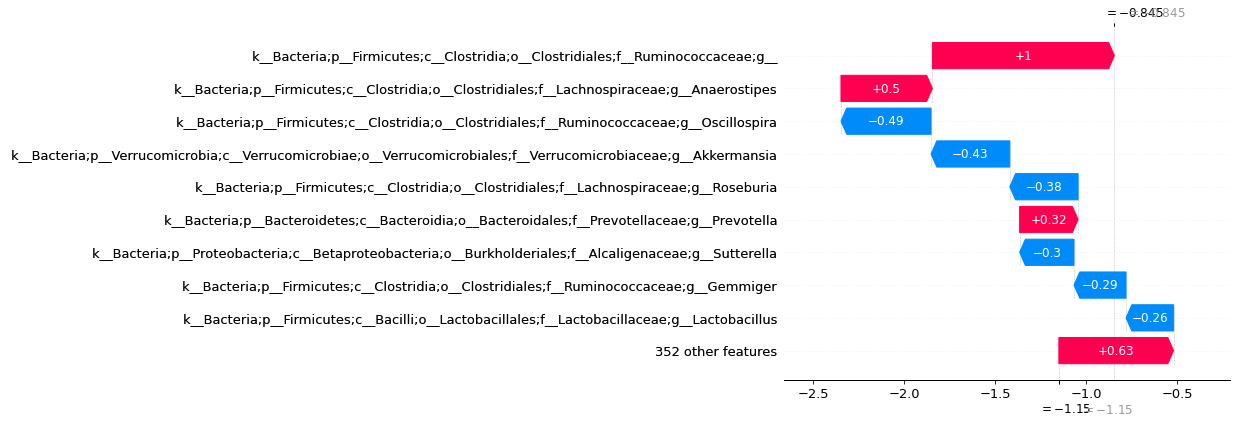

In [12]:
# random select a sample to explore the contribution of features
learner = pickle.load(open(f"output/ensemble_of_predictive_models/model/{_model[0]}.pkl", "rb"))

explainer = shap.Explainer(learner, ggmp_genus_table)
shap_values = explainer(ggmp_genus_table)
print(ggmp_genus_table.index[2020])
shap.plots.waterfall(shap_values[2020], max_display=10)

Now we apply the prediction process for each retained model, the average SHAP values of consistent features across all models as T2DM microbiome signatures.

In [13]:
def wrap_contribs(fp, data):
    """
    Wrapping model prediction results (SHAP values) as data frame
    :param fp: str, file path of retained model (pickle format)
    :param data: pandas.DataFrame, data for prediction.
    :return: pandas.DataFrame of SHAP values
    """
    bst = pickle.load(open(fp, 'rb'))
    dtest = xgb.DMatrix(data=data)
    vals = bst.predict(data=dtest,
                       ntree_limit=bst.best_iteration,
                       pred_contribs=True)
    return pd.DataFrame(vals, columns=np.append(data.columns, ['bias']), index=data.index)

In [14]:
# average SHAP values of each model prediction for GGMP cohort
model_path = [f'output/ensemble_of_predictive_models/model/{_}.pkl' for _ in _model]
ggmp_shap_values = reduce(lambda x, y: x+y, [wrap_contribs(_, ggmp_genus_table)[features] for _ in model_path]) / len(_model)

print(ggmp_shap_values.shape)
ggmp_shap_values.head()

(2603, 7)


k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium  \
SampleID                                                                                                      
G440606620                                           0.083321                                                 
G445224247                                           0.084123                                                 
G440305382                                          -0.023228                                                 
G441502202                                          -0.040652                                                 
G445302201                                           0.075658                                                 

            k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__  \
SampleID                                                                                                    
G440606620                                           0.052154                                               
G445224247                                           0.042001                                               
G440305382                                           0.026800                                               
G441502202                                          -0.059311                                               
G445302201                                           0.016737                                               

            k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__  \
SampleID                                                                       
G440606620                                          -0.001959                  
G445224247                                          -0.029271                  
G440305382                                          -0.047206                  
G441502202                                          -0.036579                  
G445302201                                           0.057174                  

            k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium  \
SampleID                                                                                                                    
G440606620                                           0.056056                                                               
G445224247                                           0.075155                                                               
G440305382                                          -0.083249                                                               
G441502202                                           0.054281                                                               
G445302201                                          -0.066283                                                               

            k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira  \
SampleID                                                                                                  
G440606620                                           0.074822                                             
G445224247                                           0.013088                                             
G440305382                                          -0.058960                                             
G441502202                                          -0.055043                                             
G445302201                                          -0.015563                                             

            k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus  \
SampleID                                                                                                   
G440606620                                           0.122251      

In [15]:
# average SHAP values of each model prediction for SGMP cohort
sgmp_shap_values = reduce(lambda x, y: x+y, [wrap_contribs(_, sgmp_genus_table)[features] for _ in model_path]) / len(_model)

print(sgmp_shap_values.shape)
sgmp_shap_values.head()

(2012, 7)


k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium  \
SampleID                                                                                                          
sam-570                                                 -0.053547                                                 
sam-477                                                  0.060271                                                 
JN-MF2-15520                                            -0.042962                                                 
JN-MF2-15218                                             0.081059                                                 
JN-TMF2-SD0168                                          -0.008288                                                 

                k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__  \
SampleID                                                                                                        
sam-570                                                 -0.017309                                               
sam-477                                                  0.054167                                               
JN-MF2-15520                                            -0.031923                                               
JN-MF2-15218                                             0.062625                                               
JN-TMF2-SD0168                                          -0.011975                                               

                k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__  \
SampleID                                                                           
sam-570                                                 -0.042371                  
sam-477                                                  0.047149                  
JN-MF2-15520                                             0.001115                  
JN-MF2-15218                                             0.053882                  
JN-TMF2-SD0168                                          -0.010651                  

                k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium  \
SampleID                                                                                                                        
sam-570                                                  0.070192                                                               
sam-477                                                  0.072391                                                               
JN-MF2-15520                                             0.047552                                                               
JN-MF2-15218                                             0.074258                                                               
JN-TMF2-SD0168                                          -0.043355                                                               

                k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira  \
SampleID                                                                                                      
sam-570                                                 -0.052453                                             
sam-477                                                  0.012348                                             
JN-MF2-15520                                             0.011650                                             
JN-MF2-15218                                             0.048912                                             
JN-TMF2-SD0168                                          -0.032453                                             

                k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus  \
SampleID                           

In [16]:
# average SHAP values of each model prediction for DFI cohort
dfi_shap_values = reduce(lambda x, y: x+y, [wrap_contribs(_, dfi_genus_table)[features] for _ in model_path]) / len(_model)

print(dfi_shap_values.shape)
dfi_shap_values.head()

(305, 7)


k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Faecalibacterium  \
SampleID                                                                                                           
DF-TMF10-15039                                            0.070527                                                 
DF-TMF10-BQ1418                                          -0.040821                                                 
DF-TMF10-CY3434                                           0.019812                                                 
DF-TMF10-BQ2518                                          -0.016886                                                 
DF-TMF10-15086                                            0.081326                                                 

                 k__Bacteria;p__Firmicutes;c__Erysipelotrichi;o__Erysipelotrichales;f__Erysipelotrichaceae;g__  \
SampleID                                                                                                         
DF-TMF10-15039                                            0.024025                                               
DF-TMF10-BQ1418                                           0.062607                                               
DF-TMF10-CY3434                                          -0.080683                                               
DF-TMF10-BQ2518                                          -0.023896                                               
DF-TMF10-15086                                            0.016108                                               

                 k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__;g__  \
SampleID                                                                            
DF-TMF10-15039                                           -0.003751                  
DF-TMF10-BQ1418                                           0.054221                  
DF-TMF10-CY3434                                          -0.044040                  
DF-TMF10-BQ2518                                          -0.046982                  
DF-TMF10-15086                                           -0.046870                  

                 k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium  \
SampleID                                                                                                                         
DF-TMF10-15039                                           -0.042027                                                               
DF-TMF10-BQ1418                                           0.069655                                                               
DF-TMF10-CY3434                                           0.013567                                                               
DF-TMF10-BQ2518                                          -0.055527                                                               
DF-TMF10-15086                                            0.072206                                                               

                 k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Oscillospira  \
SampleID                                                                                                       
DF-TMF10-15039                                            0.059792                                             
DF-TMF10-BQ1418                                           0.071156                                             
DF-TMF10-CY3434                                          -0.052917                                             
DF-TMF10-BQ2518                                          -0.061126                                             
DF-TMF10-15086                                            0.073163                                             

                 k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Lactobacillaceae;g__Lactobacillus  \


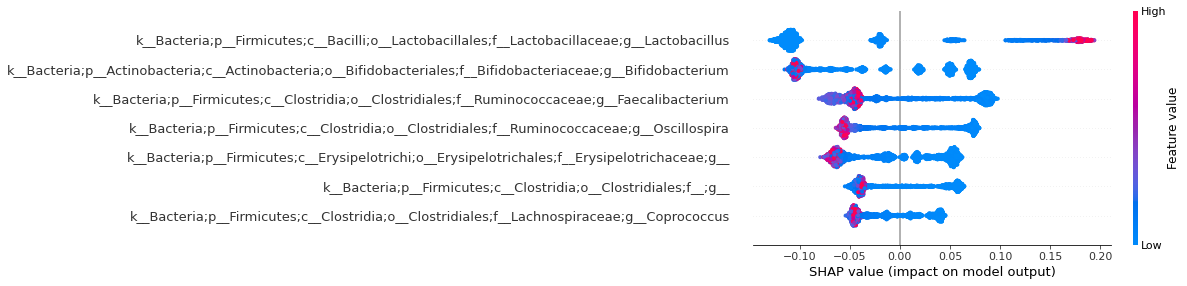

In [17]:
ggmp_shap_values.to_csv('data/GGMP_avg_SHAP_values.tsv',
                        sep='\t',
                        index_label='SampleID')
shap.summary_plot(ggmp_shap_values.values, ggmp_genus_table[features])

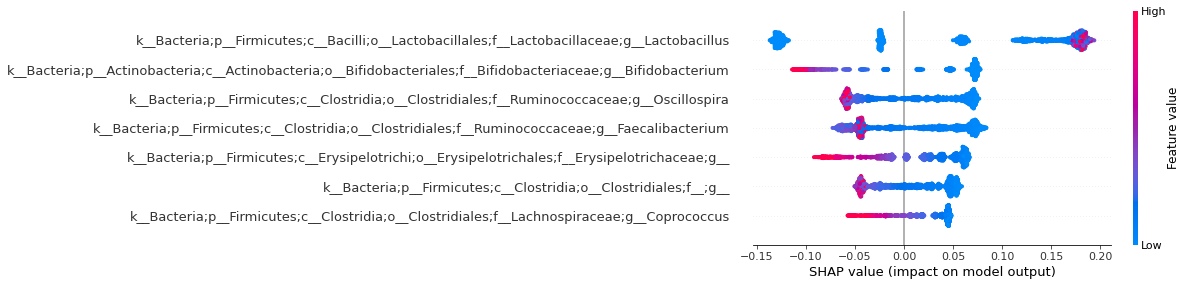

In [18]:
sgmp_shap_values.to_csv('data/SGMP_avg_SHAP_values.tsv',
                        sep='\t',
                        index_label='SampleID')
shap.summary_plot(sgmp_shap_values.values, sgmp_genus_table[features])

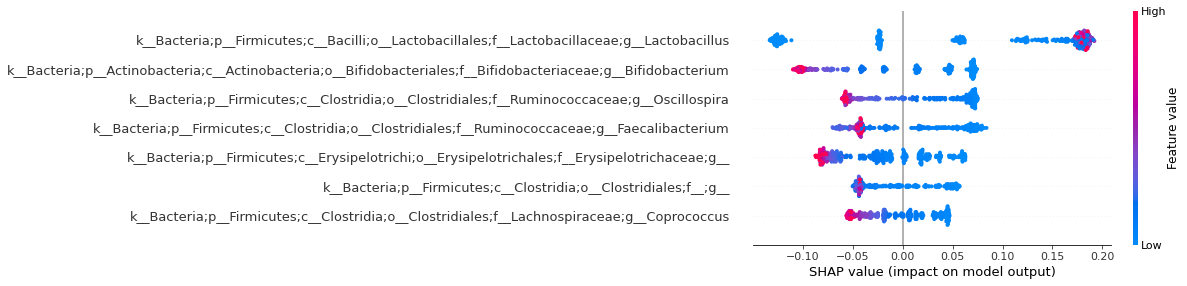

In [19]:
dfi_shap_values.to_csv('data/DFI_avg_SHAP_values.tsv',
                       sep="\t",
                       index_label="SampleID")
shap.summary_plot(dfi_shap_values.values,
                  dfi_genus_table[features])

In [20]:
# load training data & get average SHAP values of each model prediction for training set
X = pd.read_table('output/ensemble_of_predictive_models/data_X.tsv',
                  index_col=0)

shap_values = reduce(lambda x, y: x+y, [wrap_contribs(_, X)[features] for _ in model_path]) / len(_model)

print(shap_values.shape)

(3571, 7)


In [21]:
# project microbiome signatures of training set, processing for the next part (integration of signatures across cohort)
fit = TSNE(random_state=123)
embed = fit.fit_transform(shap_values)
print(f'TSNE KL divergence: {fit.kl_divergence_}')

df = pd.DataFrame(dict(Dim1=embed[:, 0],
                       Dim2=embed[:, 1],
                       Proba=shap_values.sum(1).map(expit).values,
                       Cohort=['GGMP' if _ in ggmp_genus_table.index else 'SGMP' for _ in shap_values.index]),
                   index=shap_values.index)

df.to_csv('data/Cross_cohort_SHAP_values_integration.tsv',
          sep='\t',
          index_label='SampleID')
print(df.shape)
df.head()

TSNE KL divergence: 0.8969383239746094
(3571, 4)


Dim1       Dim2     Proba Cohort
SampleID                                         
G440606620 -22.283371 -58.673965  0.599160   GGMP
G445224247 -35.892181   6.018193  0.526365   GGMP
G440305382  11.597400  -6.257991  0.440380   GGMP
G441502202 -25.899944  58.589687  0.440271   GGMP
G445302201   6.212090  18.193830  0.497718   GGMP